In [3]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

# animations, etc. requires below magic command
%matplotlib notebook


"""
Load relevant packages
"""

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import animation, cm

from scipy import stats
from scipy import optimize
from scipy.optimize import minimize, rosen, rosen_hess, rosen_der, rosen_hess_prod



"""
Own packages
"""

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

# Introduction to optimization 

In financial economics, we are often interested in maximizing or minimizing a particular objective function, e.g  estimating parameters or maximizing utility. Generally, when we want to maximize (or minimize) a function of $n$ variables $f(\mathbf{x})$ where $\mathbf{x} \in \mathbf{R}^n$ then the necessary first order conditions (FOCs) are given by 

$$
\frac{\partial f(\mathbf{x})}{\partial \mathbf{x}} = \mathbf{0}
$$

In non linear applications, it may be hard or even impossible to find an explicit solution to the first order conditions! In this Jupyter notebook, we will see how we can use numerical methods to solve optimization problems using the `scipy.optimize` package (see docs [here](https://docs.scipy.org/doc/scipy/reference/optimize.html)).


A nice tutorial for the `scipy.optimize` package can be found [here](https://docs.scipy.org/doc/scipy/tutorial/optimize.html). 

## Grid search 

The most simple way of trying to maximize a function is to simply evaluate the function over a grid and choose input values that result in the largest function value as the solution. 

`scipy.optimize` provides the function `brute` that allows us to perform a grid search. Note that `scipy.optimize` always minimizes a function. This is no problem since we can always redefine a maximization problem as a minimization problem by multiplying the objective function by minus one. 


__Example:__

Minimize the function $f(x) = x^2$. The FOC is 

$$
\frac{d f(x)}{d x} = 2 x = 0 \Rightarrow x = 0
$$

Let us try to solve with `brute`

In [2]:
def x_squared(x):
    
    return x*x

res = optimize.brute(x_squared, (slice(-10, 10),), Ns=100, full_output=True)
res[0] # global minimum

array([0.])

__Example:__

Minimize the function $f(x_1, x_1) = x_1^2 + x_2^2$. The FOCs are 

$$
\begin{align}
\frac{\partial f(x_1, x_2)}{\partial x} &= 2 x_1 = 0 \Rightarrow x_1 = 0 \\
\frac{\partial f(x_1, x_2)}{\partial y} &= 2 x_2 = 0 \Rightarrow x_2 = 0
\end{align}
$$

Again, we can solve it with `brute`. 

In [84]:
def x_squared(x):
    
    return x[0]**2 + x[1]**2


res = optimize.brute(x_squared, (slice(-10, 10), slice(-10, 10)), Ns=100, full_output=True)
res[0] # global minimum

array([0., 0.])

### Problem 

If a very fine grid can be selected, we would be able to solve all optimization problems this way. However, this will often be practically impossible. With 10 variables with only 10 grid points then we would have to check $10^{10}$ (10 billion) different points!

Nonetheless, grid search may be an important tool if other method does not work. 

## Gradient based methods


In optimization, a gradient method is simply an algorithm to solve our optimization problem, e.g. 

$$
\underset{\mathbf{x} \in \mathbb{R}^n}{\text{min}} f(\mathbf{x})
$$

with the search directions defined by the gradient (vector of first order derivatives) at the current value of the input parameters. Gradient methods will generally be defined by the updating formula 

$$
\mathbf{x}_{k+1} = \mathbf{x}_{k+1} + \mathbf{A}_k \mathbf{g}_k
$$

where $\mathbf{g}_k = \nabla f(\mathbf{x}_k)$ is the gradient and $\mathbf{A}_k$ is a matrix that depends on $\mathbf{x}$. 
Optimally, the $\mathbf{A}_k$ matrix is always  positive (negative) definite for maximization (minimization) problems.  A first order Taylor expansion evaluated at $\mathbf{x}_{k+1}$ gives 

$$
f(\mathbf{x}_{k+1}) = f(\mathbf{x}_{k}) + \mathbf{g}_k ^\top (\mathbf{x}_{k+1} - \mathbf{x}_{k}) + R = f(\mathbf{x}_{k}) + \mathbf{g}_k ^\top \mathbf{A}_k \mathbf{g}_k + R
$$

where $R$ is the remainder. Thus, if $\mathbf{A}_k$ is positive definite ($\mathbf{g}_k ^\top \mathbf{A}_k \mathbf{g}_k > 0, \; \mathbf{g}  \neq \mathbf{0}$) the function value will be increasing (if the remainder is sufficiently small). 

A range of different extensions try to improve on the above updating formula. One example is *step-size adjustment* to prevent over- or undershooting: 

$$
\mathbf{x}_{k+1} = \mathbf{x}_{k+1} + \lambda_k \mathbf{A}_k \mathbf{g}_k
$$

where $\lambda_k$ is selected using a line search to minimize or maximize $f(\mathbf{x}_{k+1})$. This may be particular usefull, when calculation of $\mathbf{A}_k$ is computationally hard. 

Another problem arise if $\mathbf{A}_k = \mathbf{B}_k^{-1}$ and $\mathbf{B}_k$ is close to singular, then a potential fix is to replace $\mathbf{B}_k$ with $\mathbf{B}_k + \mathbf{C}$ where $\mathbf{C}$ is a matrix of constants. 



### Newton-Raphson 

The [Newton-Raphson method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) is an iterative algorithm derived from a second order Taylor expansion of the objective function and the FOCs. Consider the one-dimesional problem 

$$
\underset{x \in \mathbb{R}}{\text{min}} f(x)
$$

Assuming the starting value $x_0 \in \mathbb{R}$, then we can approximate the objective function (assuming it is twice differentiable)

$$
f(x_1) \approx f(x_0) + f' (x_0) (x_1 - x_0) + \frac{1}{2} f''(x_0) (x_1 - x_0)^2
$$

The FOC is given by 

$$
\frac{d}{d x_1}\left(f(x_0) + f' (x_0) (x_1 - x_0) + \frac{1}{2} f''(x_0) (x_1 - x_0)^2 \right) = f'(x_0) + f''(x_0) (x_1 - x_0) = 0 
$$

Solving for $x_1$ yields

$$
x_1 = x_0 - \frac{f'(x_0)}{f''(x_0)}
$$

Using this procedure repeatedly gives the sequence

$$
x_{k+1} = x_{k} - \frac{f'(x_k)}{f''(x_k)}, \; \; k = 0, ..., N
$$

which under regularity conditions will converge to a local optimimum. 

__Example:__

Minimize the function $f(x) = x^2$. 

We note that 

$$
\begin{align}
f'(x) &= 2x \\
f''(x) &= 2
\end{align}
$$

Below we implement Newton's method and apply it. 

In [96]:
def newton_raphson_univariate(x0, first_der, second_der, maxiter=100): 

    sequence = list()
    sequence.append(x0)
    
    x_opt = x0
    for i in range(maxiter): 
        x_opt =  x_opt - first_der(x_opt) / second_der(x_opt)
        sequence.append(x_opt)
    
    return x_opt, sequence

In [100]:
x0 = 1.0
x_opt, sequence = newton_raphson_univariate(x0, lambda x: 2*x, lambda x: 2, maxiter=25)
print(x_opt)
print(sequence)

0.0
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


We see that the Newton-Raphson method converges after one iteration! This will be the case no matter the staring value

$$
x_1 = x_0 - \frac{2 x_0}{2} = 0
$$

This is intuitive since the method approximates the objective function with a second order polynomial. When the objective is a second order polynomial, the approximation is exact and we only need one iteration. This will generally not be the case. 

__Higher dimensions__

The one-dimensional algorithm can be generalized to higher dimensions such that 

$$
\mathbf{x}_{k+1} = \mathbf{x}_k - \mathbf{H}_k^{-1} \mathbf{g}_k
$$

where $\mathbf{g}_k = \nabla f(\mathbf{x}_k)$ is the gradient and $\mathbf{H}_k = \nabla^2 f(\mathbf{x}_k)$ is the Hessian matrix. 

From the multi-dimensional Taylor approximation

$$
f(\mathbf{x}) \approx f(\mathbf{x}_{k+1}) + \mathbf{g}_k ^\top (\mathbf{x} - \mathbf{x}_{k}) + \frac{1}{2} (\mathbf{x} - \mathbf{x}_{k})^\top \mathbf{H}_k (\mathbf{x} - \mathbf{x}_{k})
$$

we obtain by using the solution $\mathbf{x}_{k+1} = \mathbf{x}_k - \mathbf{H}_k^{-1} \mathbf{g}_k$ and some matrix algebra that 

$$
f(\mathbf{x}_{k+1}) \approx f(\mathbf{x}_{k+1}) - \frac{1}{2} (\mathbf{x}_{k+1} - \mathbf{x}_{k})^\top \mathbf{H}_k (\mathbf{x}_{k+1} - \mathbf{x}_{k})
$$

This makes it clear that the properties of the Hessian matrix are very important for convergence. E.g. if the Hessian is positive definite the function value will be decreasing. If the objective function is convex, then the Hessian matrix is positive definite over the whole domain and the method will most likely converge fast to the global minimum. However, for non-convex (and non-concave) objective functions the Hessian is not gauranteed to have nice properties and may even be singular. 

__Example:__

Consider the [Himmelblau function](https://en.wikipedia.org/wiki/Himmelblau%27s_function)

$$
f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2
$$

that has one local maxima and four local minima. 

<IPython.core.display.Javascript object>


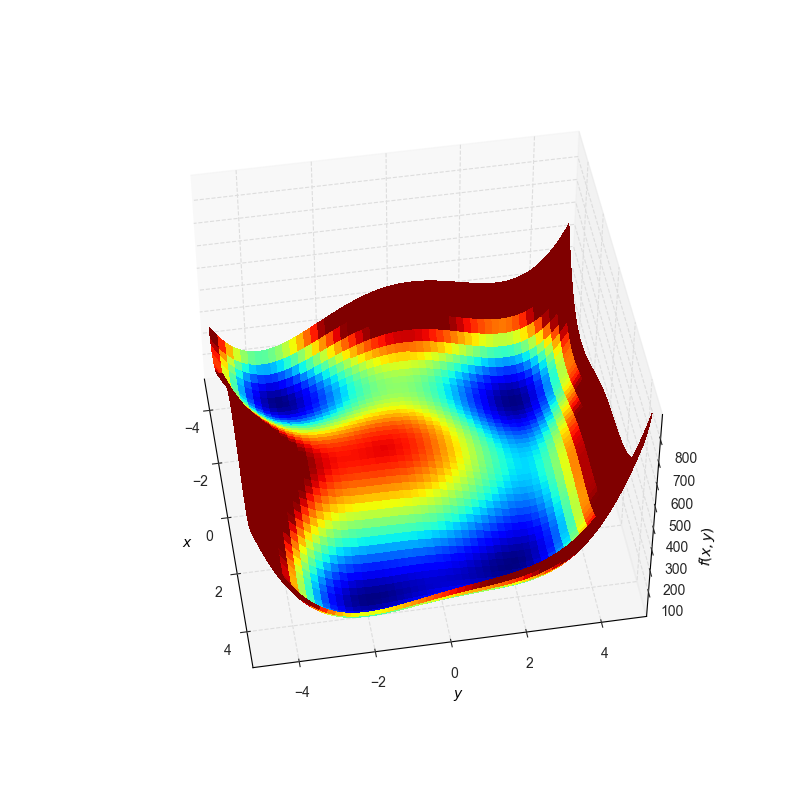

In [50]:
def himmelblau(x): 
    
    z = (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2
    
    return z 


"""
Values to plot
"""

himmelblau_plotting = lambda x, y: himmelblau([x, y])

x_vals = np.linspace(-5.0, 5.0, 1000)
y_vals = np.linspace(-5.0, 5.0, 1000)

x_mesh, y_mesh = np.meshgrid(x_vals, y_vals)
z_vals = himmelblau_plotting(x_mesh, y_mesh)

"""
3D plot
"""

# Initialize figure 
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')

# Plot the surface
surf = ax.plot_surface(x_mesh, y_mesh, z_vals, cmap=cm.jet, linewidth=0, antialiased=False,
                       vmin=0.0, vmax=200)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$f(x,y)$');

<IPython.core.display.Javascript object>


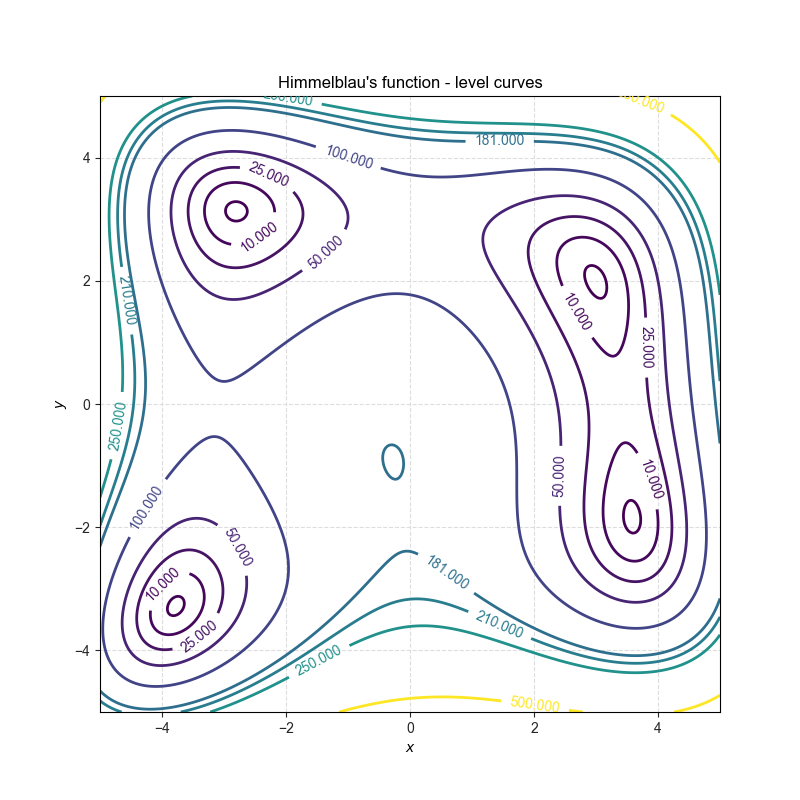

In [55]:
"""
Contour plot
"""

# Initialize figure 
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

# Plot the surface
cs = plt.contour(x_mesh, y_mesh, z_vals,
                 levels=np.array([0.0, 1.0, 10.0, 25.0, 50.0, 100.0, 181.0, 210.0, 250.0, 500.0])) 
ax.clabel(cs, inline=True, fontsize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title("Himmelblau's function - level curves");

We want to implement the Newton-Raphson method to find a local optimimum of Himmelblau's function. 

In [75]:
def newton_raphson(x0, grad, hess, maxiter=100): 
    
    sequence = list()
    sequence.append(x0)
    
    x_opt = x0
    for i in range(maxiter): 
        x_opt =  x_opt - np.linalg.inv(hess(x_opt)) @ grad(x_opt)
        sequence.append(x_opt)
    
    return x_opt, np.array(sequence)

In [76]:
def grad_himmelblau(x):
    
    grad_x = 4 * x[0] * (x[0]**2 + x[1] - 11) + 2 * (x[0] + x[1]**2 - 7)
    grad_y = 2 * (x[0]**2 + x[1] - 11) + 4 * x[1] * (x[0] + x[1]**2 - 7)
    
    return np.array([grad_x, grad_y])

def hess_himmelblau(x):
    
    hess_xx = 12 * x[0]**2 + 4 * (x[1] - 11) + 2
    hess_yy = 2 + 12 * x[1]**2 + 4 * (x[0] - 7)
    hess_xy = 4 * x[0]  + 4 * x[1]
    
    return np.array([[hess_xx, hess_xy],
                     [hess_xy, hess_yy]])

In [96]:
x_opt1, sequence1 = newton_raphson(np.array([0.0, 0.0]), grad_himmelblau, hess_himmelblau, maxiter=100)
print(x_opt1)

x_opt2, sequence2 = newton_raphson(np.array([2.0, 1.0]), grad_himmelblau, hess_himmelblau, maxiter=100)
print(x_opt2)

x_opt3, sequence3 = newton_raphson(np.array([3.0, -2.0]), grad_himmelblau, hess_himmelblau, maxiter=100)
print(x_opt3)

x_opt4, sequence4 = newton_raphson(np.array([-2.0, 4.0]), grad_himmelblau, hess_himmelblau, maxiter=100)
print(x_opt4)

x_opt5, sequence5 = newton_raphson(np.array([-4.0, -4.0]), grad_himmelblau, hess_himmelblau, maxiter=100)
print(x_opt5)

[-0.27084459 -0.92303856]
[3. 2.]
[ 3.58442834 -1.84812653]
[-2.80511809  3.13131252]
[-3.77931025 -3.28318599]


<IPython.core.display.Javascript object>


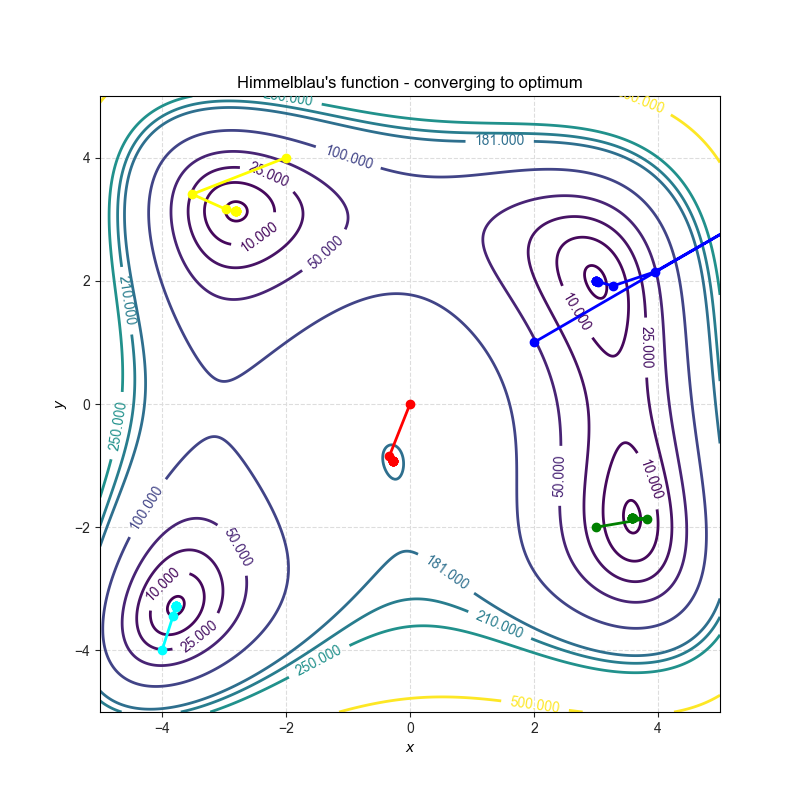

In [97]:
maxiter_used = 100

"""
Animation 
"""

# Initialize figure 
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(xlim=(-5.0, 5.0), ylim=(-5.0, 5.0))

# contour plot
cs = plt.contour(x_mesh, y_mesh, z_vals,
                 levels=np.array([0.0, 1.0, 10.0, 25.0, 50.0, 100.0, 181.0, 210.0, 250.0, 500.0])) 
ax.clabel(cs, inline=True, fontsize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title("Himmelblau's function - converging to optimum");


# scatter plot with optimal value
scatter1,  = ax.plot([sequence1[0,0]], sequence1[0,1],
                    color="red", zorder=20, marker="o")

scatter2,  = ax.plot(sequence2[0,0], sequence2[0,1],
                    color="blue", zorder=20, marker="o")

scatter3,  = ax.plot(sequence3[0,0], sequence3[0,1],
                    color="green", zorder=20, marker="o")

scatter4,  = ax.plot(sequence2[0,0], sequence2[0,1],
                    color="yellow", zorder=20, marker="o")

scatter5,  = ax.plot(sequence3[0,0], sequence3[0,1],
                    color="cyan", zorder=20, marker="o")

# animation 
def animate(i):

    scatter1.set_data(sequence1[:i+1, 0], sequence1[:i+1, 1])

    scatter2.set_data(sequence2[:i+1, 0], sequence2[:i+1, 1])

    scatter3.set_data(sequence3[:i+1, 0], sequence3[:i+1, 1])
    
    scatter4.set_data(sequence4[:i+1, 0], sequence4[:i+1, 1])

    scatter5.set_data(sequence5[:i+1, 0], sequence5[:i+1, 1])    
    
    return scatter1, scatter2, scatter3, scatter4, scatter5

anim = animation.FuncAnimation(fig, animate, frames=maxiter_used, interval=500, blit=True)

We clearly see that the local optimum reached by the method is highly dependent on the starting value!

__SciPy implementations__

`scipy.optimize.minimize` has several algorithm closely related to the above Newton-Raphson method but more robust, e.g. 

* Newton-Conjugate-Gradient algorithm (`Newton-CG`)
* Trust-Region Newton-Conjugate-Gradient algorithm (`trust-ncg`)
* Trust-Region Truncated Generalized Lanczos / Conjugate Gradient algorithm (`trust-krylov`)

Consider a 2-dimensional version of the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function) 

$$
f(x,y)=(1-x)^{2}+100(y-x^{2})^{2}
$$

with a unique minimum at $(x, y) = (1,1)$. Below, we apply the Newton-Conjugate-Gradient algorithm. 

In [104]:
res = minimize(rosen, x0, method='Newton-CG',
               jac=rosen_der, hess=rosen_hess,
               options={'xtol': 1e-8, 'disp': True})

print('Minimum at: ')
print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 22
         Gradient evaluations: 22
         Hessian evaluations: 16
Minimum at: 
[1. 1.]


### Gradient descent (or ascent)

The [gradient descent (ascent) method](https://en.wikipedia.org/wiki/Gradient_descent) applies the simple choice of an scaled identity matrix in the gradient based method $\mathbf{A}_k = \lambda_k \mathbf{I}$ such that the updating formula becomes (we will have a negative $\lambda_k$ when minimizing)

$$
\mathbf{x}_{k+1} = \mathbf{x}_{k+1} + \lambda_k \mathbf{I} \mathbf{g}_k = \mathbf{x}_{k+1} + \lambda_k \mathbf{g}_k
$$

Inuitively, the method takes a step in the direction of fastest increase. The method does not require computation of the Hessian, however the optimal learning rate $\lambda_k$ can be shown to depend on the Hessian (based on a Taylor approximation)

$$
\lambda_k = -\frac{\mathbf{g}_k^\top \mathbf{g}_k}{\mathbf{g}_k^\top \mathbf{H}_k \mathbf{g}_k}
$$

Using this formula does not require the Hessian to be non-singular, but for e.g. minimization it needs to be positive definite. There exists other Hessian free methods to set the learning rate. 

Not utilizing the Hessian in determining the direction in the updating formula may lead to slow convergence since the information about curvature of the function is not taken into account. 

Again, we consider the Rosenbrock function and try to minimize it using the Newton-Raphson and gradient descent methods. 

In [113]:
def gradient_descent(x0, grad, hess, maxiter=100): 
    
    sequence = list()
    sequence.append(x0)
    
    x_opt = x0
    for i in range(maxiter): 
        
        g = grad(x_opt)
        h = hess(x_opt)
        
        # optimal learning rate 
        opt_l = -g @ g / (g @ h @ g)
        
        x_opt =  x_opt + opt_l * g 
        
        sequence.append(x_opt)
    
    return x_opt, np.array(sequence)



In [114]:
x0 = np.array([-0.5, 0.5])

x_gd_opt1, sequence_dg_1 = gradient_descent(x0, rosen_der, rosen_hess, maxiter=100)

x_nr_opt1, sequence_nr_1 = newton_raphson(x0, rosen_der, rosen_hess, maxiter=100)

In [116]:
"""
Values to plot
"""

rosen_bivariate = lambda x, y: rosen([x, y])

x_vals = np.linspace(-2.0, 2, 1000)
y_vals = np.linspace(-1.0, 3.0, 1000)

x_mesh, y_mesh = np.meshgrid(x_vals, y_vals)
z_vals = rosen_bivariate(x_mesh, y_mesh)

<IPython.core.display.Javascript object>


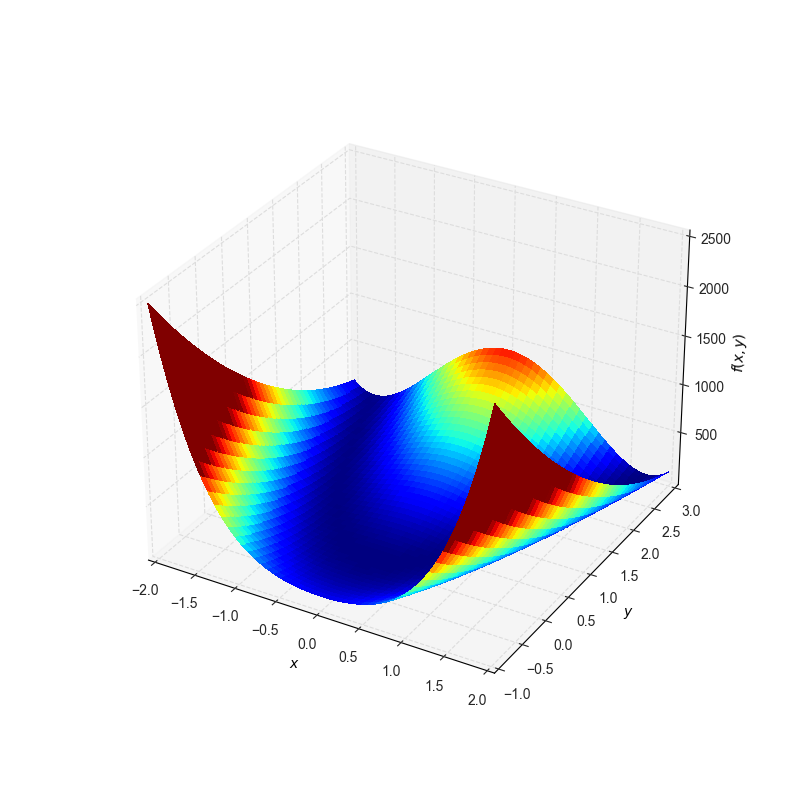

In [118]:
"""
3D plot
"""

# Initialize figure 
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')

# Plot the surface
surf = ax.plot_surface(x_mesh, y_mesh, z_vals, cmap=cm.jet, linewidth=0, antialiased=False,
                       vmin=0.0, vmax=1000)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$f(x,y)$');

<IPython.core.display.Javascript object>


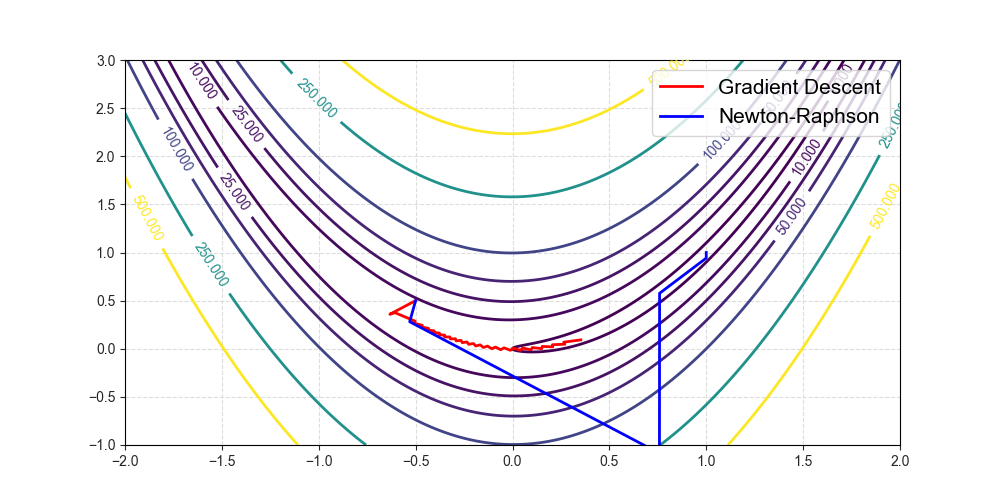

In [120]:
maxiter_used = 99

"""
Animation 
"""

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(xlim=(-2.0, 2.0), ylim=(-1.0, 3.0))

# contour plot
cs = ax.contour(x_mesh, y_mesh, z_vals, levels=np.array([0.0, 1.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0])) 
ax.clabel(cs, inline=True, fontsize=10)

# scatter plot with optimal value
scatter1,  = ax.plot([sequence_dg_1[0,0]], sequence_dg_1[0,1],
                    color="red", zorder=20, label="Gradient Descent") #, marker="o")

scatter2,  = ax.plot(sequence_nr_1[0,0], sequence_nr_1[0,1],
                    color="blue", zorder=20, label="Newton-Raphson") #, marker="o")

plt.legend();

# animation 
def animate(i):

    scatter1.set_data(sequence_dg_1[:i+1, 0], sequence_dg_1[:i+1, 1])

    scatter2.set_data(sequence_nr_1[:i+1, 0], sequence_nr_1[:i+1, 1])
  
    
    return scatter1, scatter2

anim = animation.FuncAnimation(fig, animate, frames=maxiter_used, interval=500, blit=True)

Clearly, gradient descent exhibits slow convergence. The Rosenbrock function has a narrow curved valley which contains the minimum. The bottom of the valley is very flat. Because of the curved flat valley the optimization is zigzagging slowly with small step sizes towards the minimum.

## Non-gradient based methods

### The Nelder-Mead Simplex Algorithm 

The [Nelder-Mead algorithm](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method)  is a derivative free numerical method for solving minimization and maximization problems that uses the concept of a simplex, e.g. a triangle in two dimensions (we have a function of two variables). The algorithm is purely based on function evaluations and different rules of how to contruct a new simplex

1. Ordering of points in the simplex
2. Calculation of centroid 
3. Reflection 
4. Contraction
5. Shrinkage

The figure below illustrate the concept (one of many iterations)

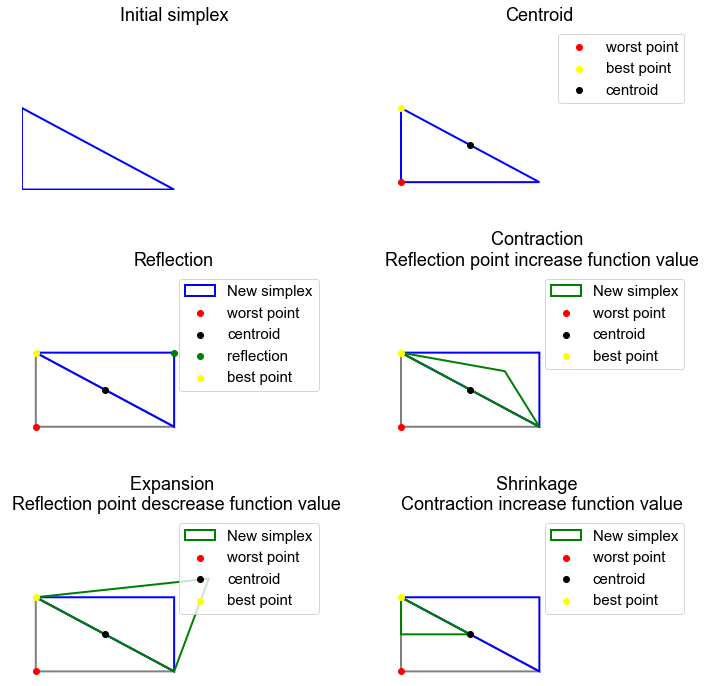

In [3]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)

# initial simplex 
ax = axes[0, 0]
ax.add_patch(Polygon((np.array([-1.0, -1.0]), np.array([0.0, -1.0]), np.array([-1.0, 0.0])), edgecolor = 'b', lw=2, fill=False))
ax.set_xlim([-1.0, 1.0])
ax.set_ylim([-1.0, 1.0])
ax.set_title("Initial simplex")
#ax.axis('equal')
ax.axis("off")

# center of gravity
ax = axes[0, 1]
ax.add_patch(Polygon((np.array([-1.0, -1.0]), np.array([0.0, -1.0]), np.array([-1.0, 0.0])), edgecolor = 'b', lw=2, fill=False))
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title("Centroid")
ax.axis("off")
ax.scatter(-1.0, -1.0, color="red", label="worst point", zorder=2)
ax.scatter(-1.0, 0.0, color="yellow", label="best point", zorder=2)
ax.scatter(-0.5, -0.5, color="black", label="centroid", zorder=2)
ax.legend()


# reflection 
ax = axes[1, 0]
ax.add_patch(Polygon((np.array([-1.0, -1.0]), np.array([0.0, -1.0]), np.array([-1.0, 0.0])), edgecolor = 'gray', lw=2, fill=False))
ax.add_patch(Polygon((np.array([0.0, 0.0]), np.array([0.0, -1.0]), np.array([-1.0, 0.0])), edgecolor = 'b', lw=2, fill=False, label = "New simplex"))

ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title("Reflection")
ax.axis("off")
ax.scatter(-1.0, -1.0, color="red", label="worst point", zorder=2)
ax.scatter(-0.5, -0.5, color="black", label="centroid", zorder=2)
ax.scatter(0.0, 0.0, color="green", label="reflection", zorder=2)
ax.scatter(-1.0, 0.0, color="yellow", label="best point", zorder=2)
ax.legend()

# contraction
ax = axes[1, 1]
ax.add_patch(Polygon((np.array([-1.0, -1.0]), np.array([0.0, -1.0]), np.array([-1.0, 0.0])), edgecolor = 'gray', lw=2, fill=False))
ax.add_patch(Polygon((np.array([0.0, 0.0]), np.array([0.0, -1.0]), np.array([-1.0, 0.0])), edgecolor = 'b', lw=2, fill=False))

ax.add_patch(Polygon((np.array([-0.25, -0.25]) , np.array([0.0, -1.0]), np.array([-1.0, 0.0])), edgecolor = 'g', lw=2, fill=False,
            label = "New simplex"))


ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title("Contraction \n Reflection point increase function value")
ax.axis("off")
ax.scatter(-1.0, -1.0, color="red", label="worst point", zorder=2)
ax.scatter(-0.5, -0.5, color="black", label="centroid", zorder=2)
ax.scatter(-1.0, 0.0, color="yellow", label="best point", zorder=2)
ax.legend()

# Expansion 
ax = axes[2, 0]
ax.add_patch(Polygon((np.array([-1.0, -1.0]), np.array([0.0, -1.0]), np.array([-1.0, 0.0])), edgecolor = 'gray', lw=2, fill=False))
ax.add_patch(Polygon((np.array([0.0, 0.0]), np.array([0.0, -1.0]), np.array([-1.0, 0.0])), edgecolor = 'b', lw=2, fill=False))

ax.add_patch(Polygon((np.array([0.25, 0.25]) , np.array([0.0, -1.0]), np.array([-1.0, 0.0])), edgecolor = 'g', lw=2, fill=False,
            label = "New simplex"))


ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title("Expansion \n Reflection point descrease function value")
ax.axis("off")
ax.scatter(-1.0, -1.0, color="red", label="worst point", zorder=2)
ax.scatter(-0.5, -0.5, color="black", label="centroid", zorder=2)
ax.scatter(-1.0, 0.0, color="yellow", label="best point", zorder=2)
ax.legend()

# Shrinkage  
ax = axes[2, 1]
ax.add_patch(Polygon((np.array([-1.0, -1.0]), np.array([0.0, -1.0]), np.array([-1.0, 0.0])), edgecolor = 'gray', lw=2, fill=False))
ax.add_patch(Polygon((np.array([0.0, 0.0]), np.array([0.0, -1.0]), np.array([-1.0, 0.0])), edgecolor = 'b', lw=2, fill=False))

ax.add_patch(Polygon((np.array([-1.0, -1.0])/2 + np.array([-1.0, 0.0])/2,
                      np.array([0.0, -1.0])/2 + np.array([-1.0, 0.0])/2,
                      np.array([-1.0, 0.0])), edgecolor = 'g', lw=2, fill=False,
                      label = "New simplex"))


ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title("Shrinkage \n Contraction increase function value")
ax.axis("off")
ax.scatter(-1.0, -1.0, color="red", label="worst point", zorder=2)
ax.scatter(-0.5, -0.5, color="black", label="centroid", zorder=2)
ax.scatter(-1.0, 0.0, color="yellow", label="best point", zorder=2)
ax.legend();

Below, we implement the Nelder-Mead described using the algoirthm outlined on [Wikipedia](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method) and apply it on the Rosenbrock function. 

In [4]:
def calculate_initial_simplex(x0, h):
    
    x1 = x0 + h * np.array([0.0, 1.0])
    x2 = x0 + h * np.array([1.0, 0.0])
    
    return (x0, x1, x2)

def nealder_mead(f, x0, alpha=1, gamma=2, rho=0.5, sigma=0.5, initial_simplex=None, h=1.0, maxiter=100, tol=1e-16): 
    
    all_simplex = list()
    
    if initial_simplex is None: 
        initial_simplex =  calculate_initial_simplex(x0, h)
        
    simplex = initial_simplex
    all_simplex.append(simplex)
    for i in range(maxiter): 
        
        # calculate function values and sort
        sorted_pointes = sorted([(_,f(_)) for _ in simplex], key=lambda x: x[1])

        best = sorted_pointes[0][0]
        mid = sorted_pointes[1][0]
        worst = sorted_pointes[2][0]
        
        # termination 
        if np.std([f(best), f(mid), f(worst)]) < tol:
            break 
        
        # calculate centroid
        centroid = (best + mid) / 2.0
        
        # reflection 
        reflect = centroid + alpha * (centroid - worst)
        if f(best) <= f(reflect) < f(mid): 
            worst = reflect
            
        # expansion 
        elif f(reflect) < f(best): 
            expand = centroid + gamma * (reflect - centroid)
            if f(expand) < f(reflect):
                worst = expand
            else: 
                worst = reflect
        
        # contract 
        elif f(reflect) >= f(mid): 
            contract = centroid + rho * (worst - centroid)
            if f(contract) < f(worst):
                worst = contract
                
            # shrink
            else: 
                mid = best + sigma*(mid - best)
                worst = best + sigma*(worst - best)
                print(0)
            
        simplex = (best, mid, worst)
        
        all_simplex.append(simplex)
        
    return {'opt': best, 'all_simplex': all_simplex}

In [5]:
res1 = nealder_mead(rosen, np.array([1.0, 0.0]))
print(res1['opt'])

res2 = nealder_mead(rosen, np.array([-1.0, 1.0]), h=0.5, maxiter=200)
print(res2['opt'])

res3 = nealder_mead(rosen, np.array([-1.0, 1.0]), h=2.0, maxiter=200)
print(res3['opt'])

res4 = nealder_mead(rosen, np.array([-1.0, 1.0]), h=3.0, maxiter=200)
print(res4['opt'])

[1. 1.]
[1.         1.00000001]
0
[1. 1.]
0
[0.99999999 0.99999998]


In [6]:
"""
Values to plot
"""

rosen_bivariate = lambda x, y: rosen([x, y])

x_vals = np.linspace(-2.0, 2, 1000)
y_vals = np.linspace(-1.0, 3.0, 1000)

x_mesh, y_mesh = np.meshgrid(x_vals, y_vals)
z_vals = rosen_bivariate(x_mesh, y_mesh)

<IPython.core.display.Javascript object>


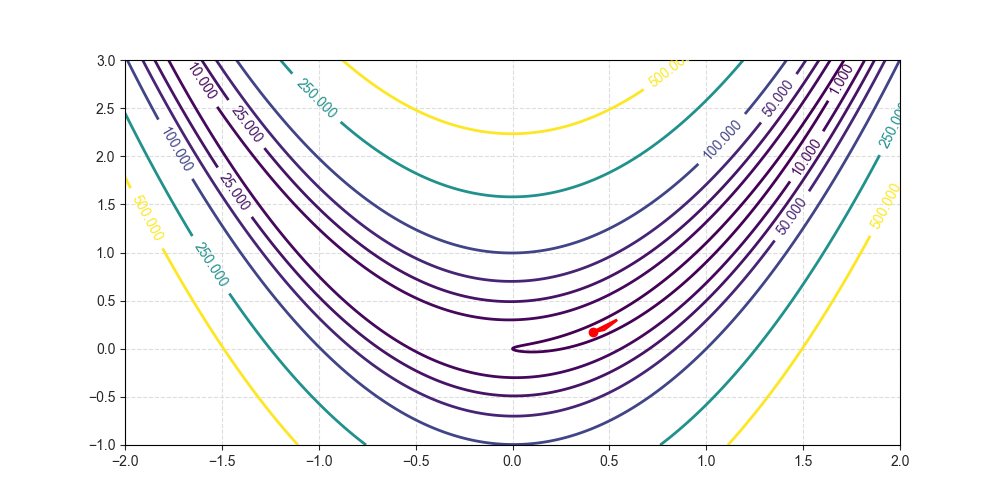

In [7]:
maxiter_used = 99

"""
Animation 
"""


# results to be used 
results = res4

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(xlim=(-2.0, 2.0), ylim=(-1.0, 3.0))

# contour plot
cs = ax.contour(x_mesh, y_mesh, z_vals, levels=np.array([0.0, 1.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0])) 
ax.clabel(cs, inline=True, fontsize=10)

# polygon 
start = [0.0 * _ for _ in results['all_simplex'][0]]
a = Polygon(start, edgecolor = 'r', lw=2, fill=False, zorder=20)
patch = ax.add_patch(a) 

# scatter plot with optimal value
scatter,  = ax.plot(results['all_simplex'][0][0][0], results['all_simplex'][0][0][1],
                    color="red", zorder=20, marker="o")

# animation 
def animate(i):

    patch.set_xy(results['all_simplex'][i])
    scatter.set_data(results['all_simplex'][i][0][0], results['all_simplex'][i][0][1])
    
    return patch, scatter

anim = animation.FuncAnimation(fig, animate, frames=maxiter_used, interval=100, blit=True)

Applying the method (probably a more robust verison, than the one implement above) from `scipy.optimize`, we would do the following

In [134]:
x0 = np.array([-1, 1])
res = minimize(rosen, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True, 'return_all': True})

res.x

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 130
         Function evaluations: 244


array([1., 1.])

## Global optimization in SciPy

We are interest in solving the problem the unconstrained minimization problem 

$$
\underset{\mathbf{x} \in \mathbb{R}^n}{\text{min}} f(\mathbf{x})
$$

So far, we have looked at algorithms that are able to find a local minimum, but we cannot be sure that the obtained solution in fact minimize the function on the whole domain if the function has many local minima. 

This motivates the use of [global optimization methods](https://en.wikipedia.org/wiki/Global_optimization) that efficiently search the parameter space and that may use local minimizers under the hood. 

In the `Scipy` [tutorial](https://docs.scipy.org/doc/scipy/tutorial/optimize.html), the eggholder function, which is notourisly hard to optimize due to many local minima, is considered

$$
f(x,y) = -(y + 47) \sin \left(\sqrt{\left \vert y + x / 2 + 47 \right \vert} \right) - x \sin \left(\sqrt{\left \vert x - y - 47 \right \vert }  \right)
$$

The function has a global minima at $f(512, 404.2319) = -959.6407$ if we only define it for $x, y \in [-512, 512]$.  

In [64]:
def eggholder(x):
     return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1]  + 47))))
             -x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]  + 47)))))

<IPython.core.display.Javascript object>


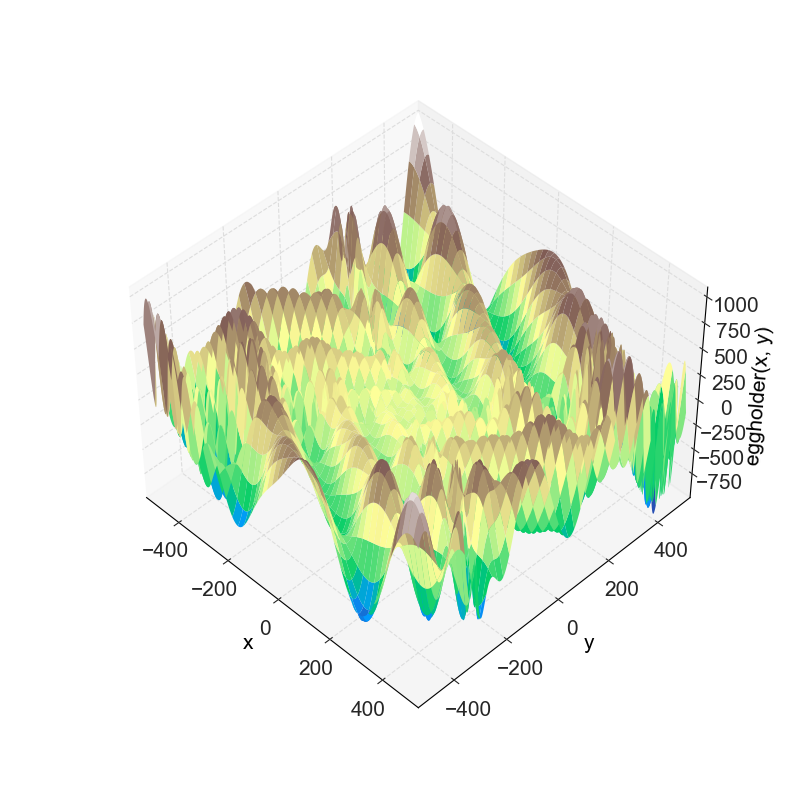

In [65]:
x = np.arange(-512, 513)
y = np.arange(-512, 513)

xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(xgrid, ygrid, eggholder(xy), cmap= 'terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('eggholder(x, y)')
plt.show()

<IPython.core.display.Javascript object>


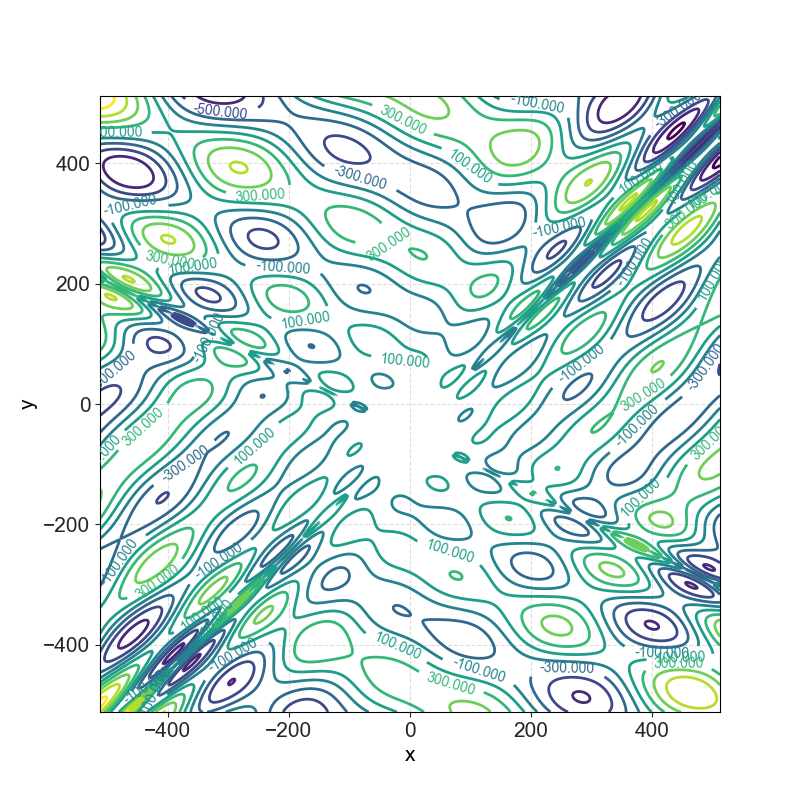

In [66]:
fig, ax = plt.subplots(figsize=(8, 8))
cs = ax.contour(xgrid, ygrid, eggholder(xy), levels=np.linspace(-900, 900, 10))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.clabel(cs, inline=True, fontsize=10);

`Scipy` contains the global optimizers 

* `basinhopping` ([`SciPy` docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html#scipy.optimize.basinhopping), [Wikipedia article](https://en.wikipedia.org/wiki/Basin-hopping))

* `brute`([`SciPy` docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html#scipy.optimize.brute))

* `differential_evolution`([`SciPy` docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html#scipy.optimize.differential_evolution), [Wikipedia article](https://en.wikipedia.org/wiki/Differential_evolution))

* `shgo` (simplicial homology global optimization) ([`SciPy` docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.shgo.html#scipy.optimize.shgo))

* `dual_annealing` ([`SciPy` docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.dual_annealing.html#scipy.optimize.dual_annealing), [Wikipedia article](https://en.wikipedia.org/wiki/Simulated_annealing))




In [74]:
"""
Basinhopping

We make sure to only apply the optimizer on the relevant interval. 
"""

# bounds that we will be using
bounds = [(-512, 512), (-512, 512)]
# dict for storing results
results = dict()

results['basinhopping'] = optimize.basinhopping(eggholder,
                                                [0.0, 0.0],
                                                minimizer_kwargs = {"method":"L-BFGS-B", "bounds":bounds},
                                                niter=1000,
                                                stepsize=20.0, 
                                                seed=np.random.seed(777))
results['basinhopping']

                        fun: -959.6406627208509
 lowest_optimization_result:       fun: -959.6406627208509
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.38557997e+00,  1.13686748e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([512.        , 404.23180511])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 31272
                        nit: 1000
                       njev: 10424
                          x: array([512.        , 404.23180511])

In [72]:
"""
Brute - takes some time ...
"""

results['brute'] = optimize.brute(eggholder, [slice(-512, 512), slice(-512, 512)], Ns=100000, full_output=True, finish=None)
results['brute'] 

(array([511., 403.]),
 -955.9638231492631,
 array([[[-512, -512, -512, ..., -512, -512, -512],
         [-511, -511, -511, ..., -511, -511, -511],
         [-510, -510, -510, ..., -510, -510, -510],
         ...,
         [ 509,  509,  509, ...,  509,  509,  509],
         [ 510,  510,  510, ...,  510,  510,  510],
         [ 511,  511,  511, ...,  511,  511,  511]],
 
        [[-512, -511, -510, ...,  509,  510,  511],
         [-512, -511, -510, ...,  509,  510,  511],
         [-512, -511, -510, ...,  509,  510,  511],
         ...,
         [-512, -511, -510, ...,  509,  510,  511],
         [-512, -511, -510, ...,  509,  510,  511],
         [-512, -511, -510, ...,  509,  510,  511]]]),
 array([[ 737.27824186,  767.94895031,  796.54630061, ..., 1043.66116912,
         1046.06382892, 1047.88711565],
        [ 705.14404176,  737.4789036 ,  767.84557317, ..., 1039.89906357,
         1042.18147464, 1043.88595089],
        [ 671.41192454,  705.28716833,  737.3143706 , ..., 1035.9168164

In [111]:
"""
Differential evolution 
"""

results['dif_evo'] = optimize.differential_evolution(eggholder, bounds=bounds, maxiter=10000, seed=4)
results['dif_evo']

     fun: -959.6406627168137
     jac: array([-3.38545492e+00, -1.36424097e-04])
 message: 'Optimization terminated successfully.'
    nfev: 1125
     nit: 36
 success: True
       x: array([512.        , 404.23174552])

In [106]:
"""
shgo
"""

results['shgo'] = optimize.shgo(eggholder, bounds=bounds, n=64, sampling_method='sobol')
results['shgo'].x, results['shgo'].fun

(array([512.        , 404.23180276]), -959.6406627208441)

<IPython.core.display.Javascript object>


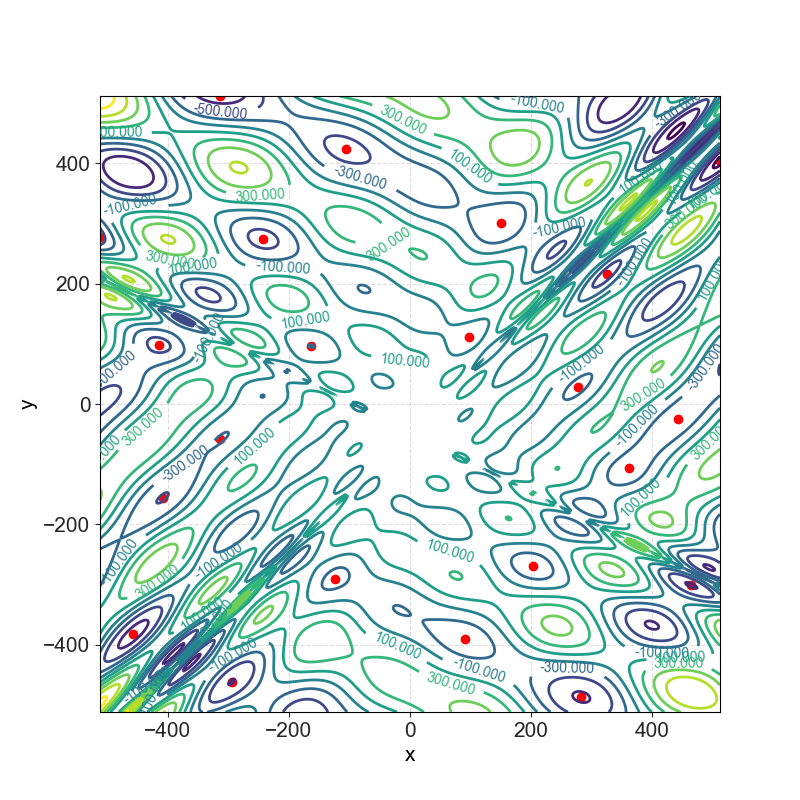

In [110]:
all_minima_found = results['shgo'].xl


fig, ax = plt.subplots(figsize=(8, 8))
cs = ax.contour(xgrid, ygrid, eggholder(xy), levels=np.linspace(-900, 900, 10))
ax.scatter(all_minima_found[:, 0], all_minima_found[:, 1], color="red")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.clabel(cs, inline=True, fontsize=10);

In [114]:
"""
dual annealing
"""

results['dual_an'] = optimize.dual_annealing(eggholder, bounds=bounds)
results['dual_an']

     fun: -959.6406627208507
 message: ['Maximum number of iteration reached']
    nfev: 4094
    nhev: 0
     nit: 1000
    njev: 31
  status: 0
 success: True
       x: array([512.        , 404.23180478])

## Bounded and constrained optimization in SciPy

Above we have looked at some examples of numerical optimizers for unbounded and unconstrained problems. `scipy.optimize.minimize` implements a range of different unconstrained optimizers (see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)). However, in many application we need to either bound the domain or implement contraints. Luckily, `scipy.optimize.minimize` also implements a range of methods for "bound-constrained" and "constrained" minimization (see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) for a full list). 

__Bounded optimization__

The default "bound-constrained" minimizer is [`L-BFGS-B`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb). 

__Example:__

Again consider the Himmelblau function

$$
f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2
$$

We want to implement the minimization problem 

$$
\underset{x,y}{\text{arg min}} f(x, y)
$$

subject to 

$$
x \in (\infty, 0] \\
y \in (\infty, 0]
$$

A simple implementation with SciPy is 

In [145]:
bounds = ((-np.inf, 0.0), (-np.inf, 0.0))

res = minimize(himmelblau, x0 = [-0.5, -0.5], bounds=bounds, method = 'L-BFGS-B')
res


      fun: 4.702662135873287e-15
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.91744066e-07,  3.57243795e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 13
     njev: 20
   status: 0
  success: True
        x: array([-3.77931026, -3.283186  ])

__Constrained optimization__

An example of a constrained minimization problem is 

$$
\underset{x,y}{\text{arg min}} f(x,y)=(1-x)^{2}+100(y-x^{2})^{2} \\
$$

subject to 

$$
x + 2y \leq 1 \\
x^2 + y \leq 1 \\
x^2 - y \leq 1 \\
2 x + y = 1 \\
0 \leq x \leq 1 \\
-0.5 \leq y \leq 2.0
$$

One available algorithm for solving such a problem is the [`SLSQP`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp) algorithm that implements [sequential least squares programming](https://en.wikipedia.org/wiki/Sequential_quadratic_programming). Both linear and nonlinear constraints are defined as dictionaries with keys `type`, `fun` and `jac`. `type` refers to whether we are dealing with a equality ('eq') or inequality constraint ('ineq'), `fun` is the function defining the constraint, and `jac` is a function defining the [Jacobian matrix](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant). Note that e.g. the constraint $x + 2y \leq 1$ can be written as $1 - x - 2y \geq 0$ which is the format we need to provide to the optimizer. 

In [148]:
# define constraints
ineq_cons = {'type': 'ineq',
             'fun' : lambda x: np.array([1 - x[0] - 2*x[1],
                                         1 - x[0]**2 - x[1],
                                         1 - x[0]**2 + x[1]]),
             'jac' : lambda x: np.array([[-1.0, -2.0],
                                         [-2*x[0], -1.0],
                                         [-2*x[0], 1.0]])}
eq_cons = {'type': 'eq',
           'fun' : lambda x: np.array([2*x[0] + x[1] - 1]),
           'jac' : lambda x: np.array([2.0, 1.0])}

bounds = [(0, 1), (-0.5, 2.0)]

x0 = np.array([0.5, 0])
res = minimize(rosen, x0, method='SLSQP', jac=rosen_der,
               constraints=[eq_cons, ineq_cons], options={'ftol': 1e-9, 'disp': True},
               bounds=bounds)

res

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.34271757499419825
            Iterations: 4
            Function evaluations: 5
            Gradient evaluations: 4


     fun: 0.34271757499419825
     jac: array([-0.82676145, -0.41372864])
 message: 'Optimization terminated successfully'
    nfev: 5
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.41494475, 0.1701105 ])

In [149]:
print(res.x)

[0.41494475 0.1701105 ]


# References

## Articles

## Books
